In [19]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder,DatasetFolder
from torch.utils.data import DataLoader,random_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from datetime import datetime
from tqdm.auto import tqdm
import json
import os
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
import torch.nn.functional as F
from transformers import ViTFeatureExtractor, ViTForImageClassification
from torch.utils.data import Dataset, DataLoader,ConcatDataset

In [3]:
# Función "collate" personalizada que utiliza el feature extractor
model2_repo_id = 'google/vit-base-patch16-224-in21k'
model2_feature_extractor = ViTFeatureExtractor.from_pretrained(model2_repo_id)

# Definir la transformación para las imágenes
rgb_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convertir imágenes de escala de grises a 3 canales (RGB)                 # Redimensionar al tamaño requerido por ViT
])

/home/mitchellmirano/Desktop/MitchellProjects/TesisMestria/src/SkyrmionClassifier/.venv/lib/python3.14/site-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [4]:
experimento = "experimento1 images"
dataset_data_dir = f"/home/mitchellmirano/Desktop/MitchellProjects/H vs J phase diagram/{experimento}"

In [5]:
class MyDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.images = [os.path.join(root, img) for img in os.listdir(root)]


    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_path = self.images[index]

        return image_path,Image.open(image_path)


In [6]:
def model2_collate_fn(batch):
    # Separa las imágenes y etiquetas
    paths, images = zip(*batch)
    # Aplica el feature extractor a la lista de imágenes (se espera que sean objetos PIL.Image)
    inputs = model2_feature_extractor(list(images), return_tensors="pt")
    return paths,inputs

In [7]:
batch_size = 32
my_dataset = MyDataset(root=dataset_data_dir, transform=rgb_transform)
data_loader = DataLoader(my_dataset, batch_size=batch_size,collate_fn=model2_collate_fn)

In [8]:
with open('classes/id2label_vit.json', 'r') as f:
    id2label = json.load(f)

with open('classes/label2id_vit.json', 'r') as f:
    label2id = json.load(f)

In [9]:
# Cargar el modelo ViT
model = torch.load("models/SkyrmionClassifierViT",weights_only=False)
# Configurar el dispositivo (GPU si está disponible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

In [10]:
for batch in data_loader:
    batch_paths, batch_inputs = batch
    model2_inputs = {k: v.to(device) for k, v in batch_inputs.items()}
    outputs = model(**model2_inputs)
    probabilities = F.softmax(outputs.logits, dim=1)
    predictions = torch.argmax(outputs.logits, dim=-1)
    print(probabilities)
    print(predictions)
    break

tensor([[0.6671, 0.1459, 0.0978, 0.0893],
        [0.6730, 0.1424, 0.0979, 0.0867],
        [0.2766, 0.3392, 0.2352, 0.1490],
        [0.1612, 0.2672, 0.3454, 0.2262],
        [0.6712, 0.1439, 0.0975, 0.0874],
        [0.6698, 0.1444, 0.0981, 0.0877],
        [0.1769, 0.2530, 0.3809, 0.1893],
        [0.1877, 0.4385, 0.2220, 0.1518],
        [0.1654, 0.2802, 0.3814, 0.1729],
        [0.6674, 0.1476, 0.0968, 0.0881],
        [0.6716, 0.1429, 0.0979, 0.0876],
        [0.5053, 0.2699, 0.1141, 0.1107],
        [0.6761, 0.1416, 0.0961, 0.0863],
        [0.6670, 0.1468, 0.0981, 0.0880],
        [0.6719, 0.1420, 0.0982, 0.0879],
        [0.6727, 0.1431, 0.0970, 0.0872],
        [0.1520, 0.2401, 0.3099, 0.2980],
        [0.6731, 0.1418, 0.0980, 0.0871],
        [0.2198, 0.4168, 0.2084, 0.1549],
        [0.6744, 0.1409, 0.0977, 0.0870],
        [0.1761, 0.2511, 0.3609, 0.2119],
        [0.6752, 0.1407, 0.0976, 0.0866],
        [0.6709, 0.1427, 0.0984, 0.0880],
        [0.6708, 0.1424, 0.0989, 0

In [11]:
id2label

{'0': 'F', '1': 'S', '2': 'Sk', '3': 'V'}

In [13]:
model.eval()

all_preds = []
all_images = []
all_probs = []

start = datetime.now()

with torch.no_grad():
    pbar = tqdm( data_loader, desc="Evaluación", total=len(data_loader), leave=False)
    for model2_batch in pbar:
        batch_paths,batch_inputs= model2_batch
        model2_inputs = {k: v.to(device) for k, v in batch_inputs.items()}
        
        # Obtener las salidas del modelo
        outputs = model(**model2_inputs)

        # Calcular las probabilidades usando softmax
        probabilities = F.softmax(outputs.logits, dim=1)

        # Obtener las predicciones
        predictions = torch.argmax(outputs.logits, dim=-1)

        # Guardar las predicciones, etiquetas y probabilidades
        all_preds.extend(predictions.cpu().numpy())
        all_images.extend(batch_paths)
        all_probs.extend(probabilities.cpu().numpy())

end = datetime.now()
delta = end - start
print(f"Inference time: {delta.total_seconds()/60:.3f} minutes")


Evaluación:   0%|          | 0/313 [00:00<?, ?it/s]

Inference time: 6.012 minutes


In [14]:
import pandas as pd

In [15]:
import re

def extract_params(file_name):
    # Expresión Regular para capturar los valores
    # Explicación de la Regex:
    # (\w+) : Captura la etiqueta (N, J2, K, H, T) en el grupo 1
    # \s*=\s* : Coincide con el patrón de ' = ' (cero o más espacios, =, cero o más espacios)
    # ([\d\.]+) : Captura el valor numérico (dígitos y puntos decimales) en el grupo 2
    pattern = r"(\w+)\s*=\s*([\d\.]+)"
    
    # Encontrar todas las coincidencias en el nombre del archivo
    matches = re.findall(pattern, file_name)
    
    # Crear un diccionario para almacenar los resultados
    parameters = {}
    for key, value in matches:
        # Convertir los valores a float si es posible, o a int para N
        if key == 'N':
            parameters[key] = int(value)
        else:
            parameters[key] = float(value)

    return parameters

In [16]:

images = [image.split("/")[-1] for image in all_images ] 
images

['skyrmionsPlot N = 547 J2 = 0.6272727272727273 K = 0.1 H = 1.7575757575757576 T = 0.01 1.png',
 'skyrmionsPlot N = 547 J2 = 0.5060606060606061 K = 0.1 H = 0.787878787878788 T = 0.01 1.png',
 'skyrmionsPlot N = 547 J2 = 0.8333333333333333 K = 0.1 H = 0.0 T = 0.01 1.png',
 'skyrmionsPlot N = 547 J2 = 0.8878787878787879 K = 0.1 H = 1.7878787878787876 T = 0.01 1.png',
 'skyrmionsPlot N = 547 J2 = 0.43333333333333335 K = 0.1 H = 1.0909090909090908 T = 0.01 1.png',
 'skyrmionsPlot N = 547 J2 = 0.6636363636363637 K = 0.1 H = 2.212121212121212 T = 0.01 1.png',
 'skyrmionsPlot N = 547 J2 = 0.5606060606060606 K = 0.1 H = 0.30303030303030304 T = 0.01 1.png',
 'skyrmionsPlot N = 547 J2 = 0.8515151515151516 K = 0.1 H = 2.090909090909091 T = 0.01 1.png',
 'skyrmionsPlot N = 547 J2 = 0.6151515151515152 K = 0.1 H = 0.2727272727272727 T = 0.01 1.png',
 'skyrmionsPlot N = 547 J2 = 0.6212121212121212 K = 0.1 H = 1.3636363636363635 T = 0.01 1.png',
 'skyrmionsPlot N = 547 J2 = 0.3 K = 0.1 H = 1.242424242

In [17]:
id2label = {int(i):k for i, k in id2label.items()}
id2label

{0: 'F', 1: 'S', 2: 'Sk', 3: 'V'}

In [21]:
probs_df = pd.DataFrame(np.array(all_probs).round(3), columns=[label for label in list(id2label.values())])
probs_df

,F,S,Sk,V
0,0.667,0.146,0.098,0.089
1,0.673,0.142,0.098,0.087
2,0.277,0.339,0.235,0.149
3,0.161,0.267,0.345,0.226
4,0.671,0.144,0.097,0.087
...,...,...,...,...
9995,0.163,0.338,0.309,0.190
9996,0.216,0.427,0.207,0.150
9997,0.674,0.141,0.098,0.087
9998,0.161,0.361,0.309,0.168


In [22]:
df = pd.DataFrame({'experimento': len(images)*[experimento]})
df['image'] = images

Ns = []
J2s = []
Ks = []
Hs = []
Ts = []
for image in df['image']:
    params = extract_params(image)
    Ns.append(params['N'])
    J2s.append(params['J2'])
    Ks.append(params['K'])
    Hs.append(params['H'])
    Ts.append(params['T'])
df['N'] = Ns
df['K'] = Ks
df['T'] = Ts
df['H'] = Hs
df['J2'] = J2s
df = pd.concat([df, probs_df], axis=1)
df['id'] = all_preds
df['label'] = df['id'].map(id2label)
df.to_excel(f'predictions/HvsJ_vit_inference_{experimento}.xlsx', index=False)
df

,experimento,image,N,K,T,H,J2,F,S,Sk,V,id,label
0,experimento1 images,skyrmionsPlot N = 547 J2 = 0.6272727272727273 ...,547,0.1,0.01,1.757576,0.627273,0.667,0.146,0.098,0.089,0,F
1,experimento1 images,skyrmionsPlot N = 547 J2 = 0.5060606060606061 ...,547,0.1,0.01,0.787879,0.506061,0.673,0.142,0.098,0.087,0,F
2,experimento1 images,skyrmionsPlot N = 547 J2 = 0.8333333333333333 ...,547,0.1,0.01,0.000000,0.833333,0.277,0.339,0.235,0.149,1,S
3,experimento1 images,skyrmionsPlot N = 547 J2 = 0.8878787878787879 ...,547,0.1,0.01,1.787879,0.887879,0.161,0.267,0.345,0.226,2,Sk
4,experimento1 images,skyrmionsPlot N = 547 J2 = 0.43333333333333335...,547,0.1,0.01,1.090909,0.433333,0.671,0.144,0.097,0.087,0,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,experimento1 images,skyrmionsPlot N = 547 J2 = 0.5666666666666667 ...,547,0.1,0.01,0.212121,0.566667,0.163,0.338,0.309,0.190,1,S
9996,experimento1 images,skyrmionsPlot N = 547 J2 = 0.4696969696969696 ...,547,0.1,0.01,0.060606,0.469697,0.216,0.427,0.207,0.150,1,S
9997,experimento1 images,skyrmionsPlot N = 547 J2 = 0.3303030303030303 ...,547,0.1,0.01,1.393939,0.330303,0.674,0.141,0.098,0.087,0,F
9998,experimento1 images,skyrmionsPlot N = 547 J2 = 0.6393939393939394 ...,547,0.1,0.01,0.606061,0.639394,0.161,0.361,0.309,0.168,1,S


In [23]:
df = pd.read_excel(f'predictions/HvsJ_vit_inference_{experimento}.xlsx')
df

,experimento,image,N,K,T,H,J2,F,S,Sk,V,id,label
0,experimento1 images,skyrmionsPlot N = 547 J2 = 0.6272727272727273 ...,547,0.1,0.01,1.757576,0.627273,0.667,0.146,0.098,0.089,0,F
1,experimento1 images,skyrmionsPlot N = 547 J2 = 0.5060606060606061 ...,547,0.1,0.01,0.787879,0.506061,0.673,0.142,0.098,0.087,0,F
2,experimento1 images,skyrmionsPlot N = 547 J2 = 0.8333333333333333 ...,547,0.1,0.01,0.000000,0.833333,0.277,0.339,0.235,0.149,1,S
3,experimento1 images,skyrmionsPlot N = 547 J2 = 0.8878787878787879 ...,547,0.1,0.01,1.787879,0.887879,0.161,0.267,0.345,0.226,2,Sk
4,experimento1 images,skyrmionsPlot N = 547 J2 = 0.43333333333333335...,547,0.1,0.01,1.090909,0.433333,0.671,0.144,0.097,0.087,0,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,experimento1 images,skyrmionsPlot N = 547 J2 = 0.5666666666666667 ...,547,0.1,0.01,0.212121,0.566667,0.163,0.338,0.309,0.190,1,S
9996,experimento1 images,skyrmionsPlot N = 547 J2 = 0.4696969696969696 ...,547,0.1,0.01,0.060606,0.469697,0.216,0.427,0.207,0.150,1,S
9997,experimento1 images,skyrmionsPlot N = 547 J2 = 0.3303030303030303 ...,547,0.1,0.01,1.393939,0.330303,0.674,0.141,0.098,0.087,0,F
9998,experimento1 images,skyrmionsPlot N = 547 J2 = 0.6393939393939394 ...,547,0.1,0.01,0.606061,0.639394,0.161,0.361,0.309,0.168,1,S


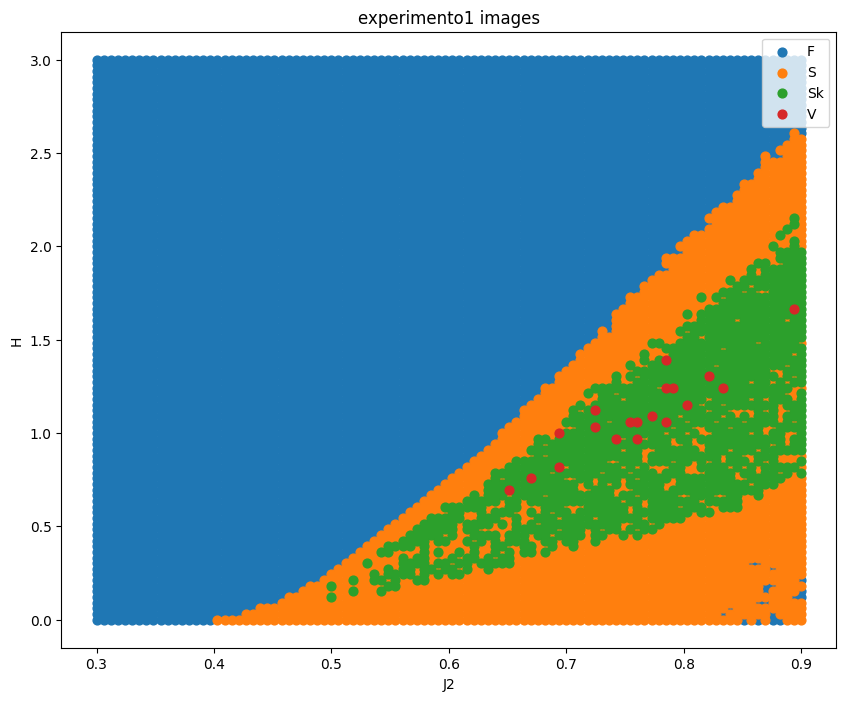

In [24]:
plt.figure(figsize=(10, 8))

for label, count in df['label'].value_counts( ascending=False).items():
    subset = df[df['label'] == label]
    plt.scatter(subset['J2'], subset['H'], label=label, s=40)
    
plt.xlabel('J2')
plt.ylabel('H')
plt.title(experimento)
plt.legend()
plt.savefig(f'predictions/HvsJ_vit_inference_{experimento}.png')
plt.show()

In [40]:
test_df=df[(df["label"]=='F') & (df["H"]<0.5) & (df["J2"]>=0.8)].copy()
test_df["images"] = [ os.path.join(dataset_data_dir, img) for img in test_df['image']]
test_df

,experimento,image,N,K,T,H,J2,F,S,Sk,V,id,label,images
38,experimento1 images,skyrmionsPlot N = 547 J2 = 0.893939393939394 K...,547,0.1,0.01,0.121212,0.893939,0.449,0.226,0.190,0.135,0,F,/home/mitchellmirano/Desktop/MitchellProjects/...
577,experimento1 images,skyrmionsPlot N = 547 J2 = 0.8393939393939394 ...,547,0.1,0.01,0.060606,0.839394,0.389,0.296,0.201,0.115,0,F,/home/mitchellmirano/Desktop/MitchellProjects/...
1081,experimento1 images,skyrmionsPlot N = 547 J2 = 0.9 K = 0.1 H = 0.1...,547,0.1,0.01,0.121212,0.900000,0.376,0.297,0.209,0.117,0,F,/home/mitchellmirano/Desktop/MitchellProjects/...
1148,experimento1 images,skyrmionsPlot N = 547 J2 = 0.8757575757575757 ...,547,0.1,0.01,0.030303,0.875758,0.332,0.330,0.216,0.121,0,F,/home/mitchellmirano/Desktop/MitchellProjects/...
1233,experimento1 images,skyrmionsPlot N = 547 J2 = 0.8757575757575757 ...,547,0.1,0.01,0.181818,0.875758,0.353,0.315,0.212,0.120,0,F,/home/mitchellmirano/Desktop/MitchellProjects/...
1392,experimento1 images,skyrmionsPlot N = 547 J2 = 0.8818181818181818 ...,547,0.1,0.01,0.000000,0.881818,0.344,0.339,0.195,0.122,0,F,/home/mitchellmirano/Desktop/MitchellProjects/...
1886,experimento1 images,skyrmionsPlot N = 547 J2 = 0.8515151515151516 ...,547,0.1,0.01,0.000000,0.851515,0.347,0.331,0.196,0.127,0,F,/home/mitchellmirano/Desktop/MitchellProjects/...
2145,experimento1 images,skyrmionsPlot N = 547 J2 = 0.9 K = 0.1 H = 0.2...,547,0.1,0.01,0.212121,0.900000,0.380,0.300,0.204,0.115,0,F,/home/mitchellmirano/Desktop/MitchellProjects/...
2581,experimento1 images,skyrmionsPlot N = 547 J2 = 0.8636363636363638 ...,547,0.1,0.01,0.090909,0.863636,0.334,0.320,0.208,0.139,0,F,/home/mitchellmirano/Desktop/MitchellProjects/...
2630,experimento1 images,skyrmionsPlot N = 547 J2 = 0.8696969696969697 ...,547,0.1,0.01,0.181818,0.869697,0.364,0.303,0.207,0.126,0,F,/home/mitchellmirano/Desktop/MitchellProjects/...


IndexError: index 5 is out of bounds for axis 0 with size 5

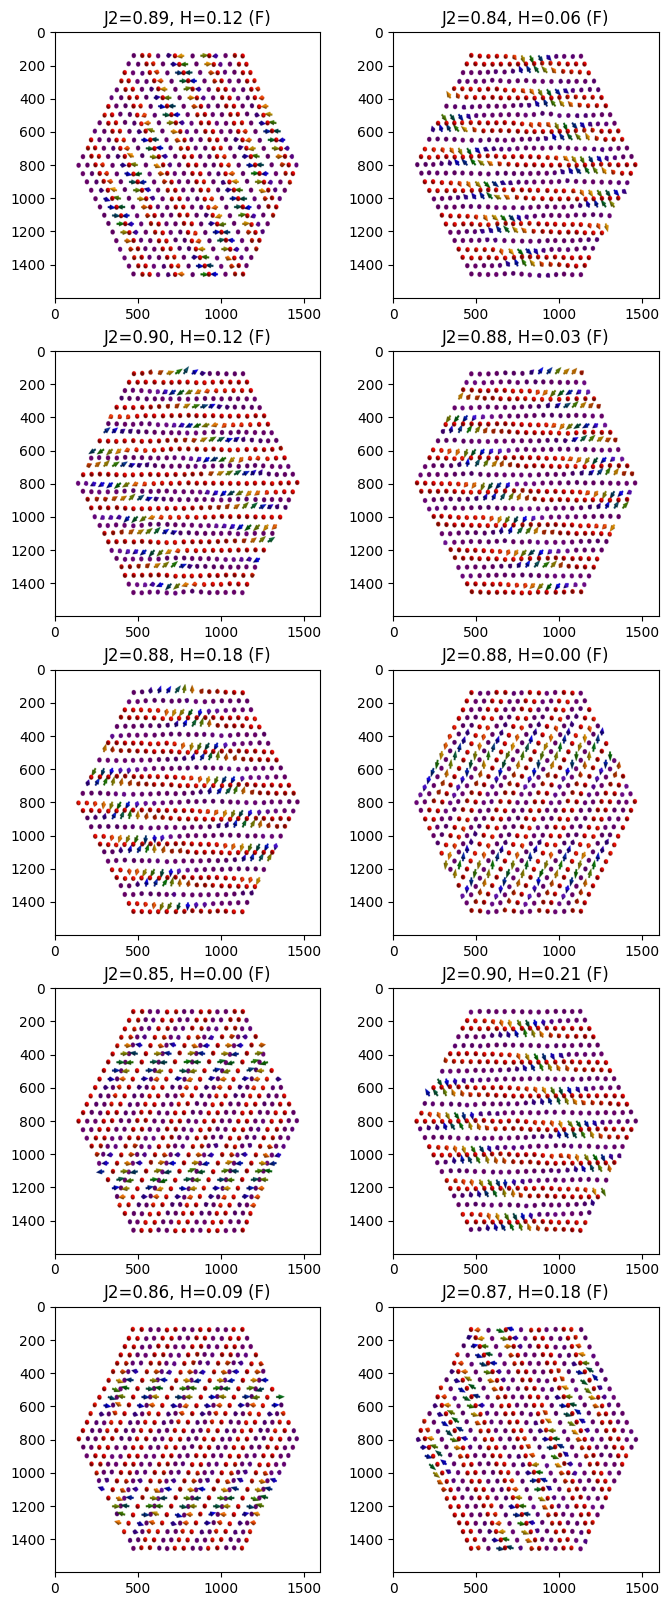

In [41]:
fig, ax = plt.subplots(5, 2, figsize=(8, 20))
for i, (index, row) in enumerate(test_df.iterrows()):
    ax[i//2, i%2].imshow(Image.open(row['images']))
    ax[i//2, i%2].set_title(f"J2={row['J2']:.2f}, H={row['H']:.2f} ({row['label']})")
    # ax[i//2, i%2].axis('off')
plt.tight_layout()